In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r'C:/Users/ruonan.ding/Desktop/SBU_example_Surveydata_2014.csv',
                   encoding="cp1252")

In [3]:
continuousVar = data.describe().columns
categoricalVar = [i for i in data.columns if i not in continuousVar]

In [4]:
def deleteNonEffVar(data):
    nullColumns = []
    for col in data.columns:
        if len(data[col].factorize()[1]) == 1:
            nullColumns.append(col)
            continue
        nullPercentage = data[col].isnull().sum() / data.shape[0]
        if nullPercentage >= 0.5:
            nullColumns.append(col)
    return data.drop(nullColumns, axis = 1)

In [5]:
data2 = deleteNonEffVar(data)

## Feature Cleaning and Engineering

In [6]:
#Find out the portion with that are not Yes or No

In [7]:
data3 = data2[data2.columns[19:]]

In [8]:
optionalQ = []
for col in data3.columns:
    tol = sum([1 for x in data3[col] if str(x).find("Missing") != -1])
    if tol > 1000:
        # print(col, tol)
        optionalQ.append(col)

In [9]:
data4 = data3.drop(optionalQ, axis = 1) 

In [10]:
data4 = data4[(data4['DIABETE3'] != 'Refused')]
data4 = data4[(data4['DIABETE3'] != 'Don’t know/Not Sure')]

In [11]:
another_Col = ['DIABETE3',"GENHLTH", "HLTHPLN1",
"EXERANY2", "CVDINFR4", "CVDCRHD4", "CVDSTRK3",
"ASTHMA3", "CHCSCNCR", "CHCOCNCR", "CHCCOPD", "HAVARTH3", "ADDEPEV2", "CHCKIDNY",
"AGE", "MARITAL" , "CHILDREN" , "EDUCA" , "EMPLOY1" , "INCOME2" , "SEX" ,
"QLACTLM2" , "USEEQUIP" , "BLIND" ,  "DECIDE" , "DIFFWALK" , "DIFFDRES" , "DIFFALON" ,
"USENOW3" , "ALCDAY5" , "PNEUVAC3" , "SEATBELT" , "BMI5CAT" , "RFBMI5" ,
"RFSMOK3" , "DRNKANY5"]

In [12]:
data5 = data4[another_Col]

In [13]:
##categorical variables converts to Dummys##catego 
def make_dummies(df, variables):
    for variable in variables:
        dummies = pd.get_dummies(df[variable], prefix = variable + '_')
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(variable, axis = 1)
    return df

In [14]:
y_target = pd.Series(np.where(data5['DIABETE3'].str.contains('Yes'), 1, 0))

In [15]:
X_full = make_dummies(data5.drop(['DIABETE3'], axis=1), data5.drop(['DIABETE3'], axis=1).columns)

## Training Data

In [105]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, 
                                                    y_target, 
                                                    test_size=0.3, 
                                                    random_state=10)

In [17]:
from sklearn import ensemble

randomForest = ensemble.RandomForestClassifier(random_state = 1)

In [19]:
import sklearn.grid_search as gs

grid_para_tree = {"n_estimators": [100, 300],
                  "min_samples_leaf": [8, 9, 10,15],
                  "max_features": [None]}
grid_search_tree = gs.GridSearchCV(randomForest, grid_para_tree, cv=5,
                                   scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300], 'min_samples_leaf': [8, 9, 10, 15], 'max_features': [None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [20]:
print(grid_search_tree.best_params_)
print(grid_search_tree.best_score_)

{'max_features': None, 'min_samples_leaf': 10, 'n_estimators': 300}
0.8711157455683003


In [21]:
randomForest.set_params(n_estimators = 300, max_features =  None, min_samples_leaf = 10, random_state = 1)
randomForest.fit(X_train, y_train)
print ("The training error of random forest is: %.5f" %(1-randomForest.score(X_train, y_train)))
print ("The test error of random forest is: %.5f" %(1-randomForest.score(X_test, y_test)))

The training error of random forest is: 0.10657
The test error of random forest is: 0.12451


In [23]:
feature_importance = randomForest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
top20_sorted_idx = np.argsort(feature_importance)[::-1][:20]
pos = np.arange(top20_sorted_idx.shape[0]) + .5

#for i in sorted_idx[:30]:
#    print(X_train.columns[i], feature_importance[i])

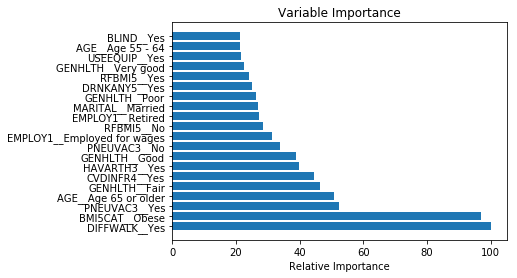

In [28]:
# plot
import matplotlib.pyplot as plt

plt.barh(pos, feature_importance[top20_sorted_idx], align='center')
plt.yticks(pos, X_train.columns.values[top20_sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Model Evaluation

In [29]:
from sklearn.metrics import roc_curve

# The random forest model by itself
y_pred_rf = randomForest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_rf, pos_label = 1)

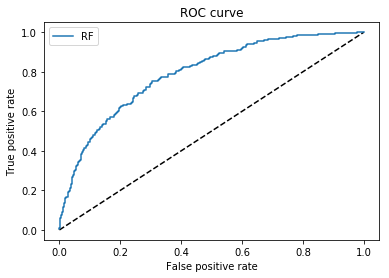

In [30]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [107]:
confusion_matrix(y_target, randomForest.predict(X_full))

array([[5922,   36],
       [ 229,  664]])

Populating the interactive namespace from numpy and matplotlib


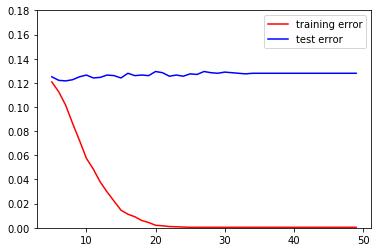

In [84]:
depth = range(5, 50)
train_error = []
test_error = []
for i in depth:
    randomForest.set_params(max_depth = i, min_samples_leaf=1, n_estimators = 100)
    randomForest.fit(X_train, y_train)
    train_error.append(1 - randomForest.score(X_train, y_train))
    test_error.append(1 - randomForest.score(X_test, y_test))

%pylab inline
import matplotlib.pyplot as pl
pl.plot(depth, train_error, c = 'red', label = 'training error')
pl.plot(depth, test_error, c = 'blue', label = 'test error')
pl.ylim(0, 0.18)
pl.legend()
pl.show()